In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from experiments2.auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
from bamt.networks.continuous_bn import ContinuousBN
from bamt.networks.hybrid_bn import HybridBN

from tqdm import tqdm

imagespath = 'error_gradation_images'

In [68]:
data = pd.read_csv("../../datasets/abalone.data", sep=',', names=['sex', 'length', 'diameter', 'height', 'W_weight', 'S_weight', 'viscera_weight', 'shell_weight', 'rings'])
data.drop(columns=["sex"], inplace=True)
n_features = data.shape[1]-1
n = data.shape[0]
target = "rings"
features = data.columns.difference([target]).tolist()

data.head(10)

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


In [69]:
#sns.pairplot(data=data)

In [70]:
def entropy(a):
    vc = a.value_counts()
    vc/=vc.sum()
    return -(vc*np.log(vc)).sum()

In [71]:
def discretize(data, variables, icat, icont, contdiscstrategy="kmeans", n_bins=3):
    transformers_data = dict()
    
    if icat is None: # в датасете только непрерывные фичи (и предиктор)
        pipeline = make_pipeline(
            KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy), 
            FunctionTransformer(lambda x: x.astype("int")))
    elif icont is None: # в датасете только категориальные фичи (и предиктор)
        pipeline = make_pipeline(
            OrdinalEncoder(categories="auto"), 
            FunctionTransformer(lambda x: x.astype("int")))
    else:
        pipeline = make_pipeline(make_union(
        make_pipeline(FunctionTransformer(lambda x: x.iloc[:, icat]), OrdinalEncoder(categories="auto")),
        make_pipeline(FunctionTransformer(lambda x: x.loc[:, icont]), KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy))
    ),
        FunctionTransformer(lambda x: x.astype("int")))
    
    
    pipeline.fit(data)
    encoded_data = pd.DataFrame(pipeline.transform(data), columns=data.columns if icat is None or icont is None\
                                                                                        else data.columns[icat+icont])
    encoded_data = encoded_data[variables] # в общем случае пайплайн переставляет признаки, возвращаем их на их места здесь

    for feat in encoded_data.columns:
        if entropy(encoded_data[feat]) < 0.5:
            print(f"Warning: feature {feat} has practically degenerate states and low entropy")
    transformers_data["transformer"] = pipeline
    
    if icat is None:
        transformers_data["cont_features"]       = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cont_features_edges"] = pipeline.steps[0][1].bin_edges_
        
    elif icont is None:
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].categories_
        
    else:
        transformers_data["cont_features"]           = list(pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].get_feature_names_out())
        transformers_data["cont_features_edges"]     = pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].bin_edges_
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_
    
    #kmeanspipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_[0]
    return encoded_data, transformers_data

#disc_data, pipeline_data = discretize(data, variables, icat=None, icont=[0, 1])


In [72]:
data = data[data["height"]<0.26].reset_index().drop(columns=["index"])

In [73]:
#data.reset_index().drop(columns=["index"])

In [74]:
model = GradientBoostingRegressor(n_estimators=30)
#model = LinearRegression()
model.fit(data[features], data[target])

GradientBoostingRegressor(n_estimators=30)

In [75]:
data_errors = data.copy(deep=True)
data_errors["ape_error"] = np.abs((data[target]-model.predict(data[features]))/data[target])
#data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings,ape_error
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0.423826
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0.074583
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0.177560
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0.023819
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0.009314


In [108]:
features = data_errors.columns[:-2].to_list()

In [77]:
disc_data, pipeline_data = discretize(data_errors, features+["ape_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings,ape_error
0,1,1,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,1,0,0
3,1,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
4170,2,2,2,1,1,1,1,1,0
4171,2,2,1,1,1,1,1,0,0
4172,2,2,2,1,1,2,1,0,0
4173,2,2,1,1,1,1,1,0,0


In [78]:
#data = data[data["height"]<0.26]
#disc_data, pipeline_data = discretize(data, features, icat=None, icont=list(range(n_features)))

In [79]:
v = pipeline_data["cont_features_edges"]
v[8] = [v[8][0], (v[8][0] + v[8][1]) / 2, v[8][1], v[8][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v
data__ = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=disc_data.columns)
data__

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings,ape_error
0,1,1,0,0,0,0,0,1,2
1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,1,0,1
3,1,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
4170,2,2,2,1,1,1,1,1,0
4171,2,2,1,1,1,1,1,0,0
4172,2,2,2,1,1,2,1,0,1
4173,2,2,1,1,1,1,1,0,0


In [80]:
data__["ape_error"].value_counts()

ape_error
0    1707
2    1281
1    1187
Name: count, dtype: int64

In [81]:
disc_data = data__

<AxesSubplot: >

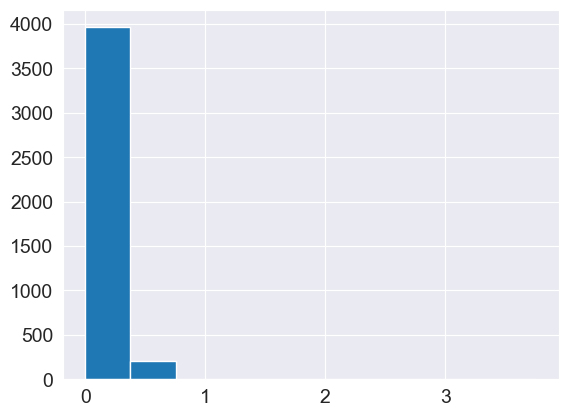

In [82]:
data_errors["ape_error"].hist()

In [83]:
current_error = data_errors["ape_error"].sum()/n
current_error

0.15496210534140756

In [84]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore

def collect_all_cpds(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            #cpd_list = [probs for i, probs in distributions[feat]["cprob"].items() if i[0]!="["]
            #print(cpd_list)
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            #print(feat, row["parents"])
            #print(cpd_list)
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"], evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds



In [85]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'length': 3,
 'diameter': 3,
 'height': 3,
 'W_weight': 3,
 'S_weight': 3,
 'viscera_weight': 3,
 'shell_weight': 3,
 'rings': 3,
 'ape_error': 3}

In [86]:
cbn = ContinuousBN(use_mixture=True)

nodes_data = {"types": {feat: "cont" for feat in data_errors.columns},
               "signs": {feat: "pos" for feat in data_errors.columns}}
nodes_data["types"][target] = "cont"
nodes_data["signs"][target] = "pos"

cbn.add_nodes(nodes_data)

blacklist = [(x, "ape_error") for x in features+[target]]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)
cbn.add_edges(disc_data, scoring_function=("K2", K2Score), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [87]:
disc_data

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings,ape_error
0,1,1,0,0,0,0,0,1,2
1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,1,0,1
3,1,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
4170,2,2,2,1,1,1,1,1,0
4171,2,2,1,1,1,1,1,0,0
4172,2,2,2,1,1,2,1,0,1
4173,2,2,1,1,1,1,1,0,0


In [88]:
cbn.get_info()

,name,node_type,data_type,parents,parents_types
0,ape_error,MixtureGaussian,cont,[],[]
1,rings,MixtureGaussian,cont,[ape_error],[cont]
2,shell_weight,MixtureGaussian,cont,"[rings, ape_error]","[cont, cont]"
3,diameter,MixtureGaussian,cont,"[shell_weight, rings]","[cont, cont]"
4,W_weight,MixtureGaussian,cont,"[diameter, shell_weight]","[cont, cont]"
5,length,MixtureGaussian,cont,"[diameter, W_weight]","[cont, cont]"
6,S_weight,MixtureGaussian,cont,"[length, W_weight, rings]","[cont, cont, cont]"
7,viscera_weight,MixtureGaussian,cont,"[length, W_weight]","[cont, cont]"
8,height,MixtureGaussian,cont,"[diameter, viscera_weight, shell_weight]","[cont, cont, cont]"


In [89]:
data_errors

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings,ape_error
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0.423826
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0.074583
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,0.177560
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0.023819
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0.009314
...,...,...,...,...,...,...,...,...,...
4170,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,0.037813
4171,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0.021677
4172,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0.195373
4173,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,0.034774


In [90]:
cbn.fit_parameters(data_errors)

In [91]:
low = data_errors[disc_data["ape_error"] == 0]["ape_error"].mean()
high = data_errors[disc_data["ape_error"] == 2]["ape_error"].mean()


le_data = cbn.sample(1000, evidence={"ape_error": low})[data_errors.columns]
le_data_disc=pd.DataFrame(pipeline_data["transformer"].transform(le_data), columns=data_errors.columns)
he_data = cbn.sample(1000, evidence={"ape_error": high})[data_errors.columns]
he_data_disc=pd.DataFrame(pipeline_data["transformer"].transform(he_data), columns=data_errors.columns)

100%|██████████| 1000/1000 [00:28<00:00, 34.48it/s]


<Figure size 640x480 with 0 Axes>

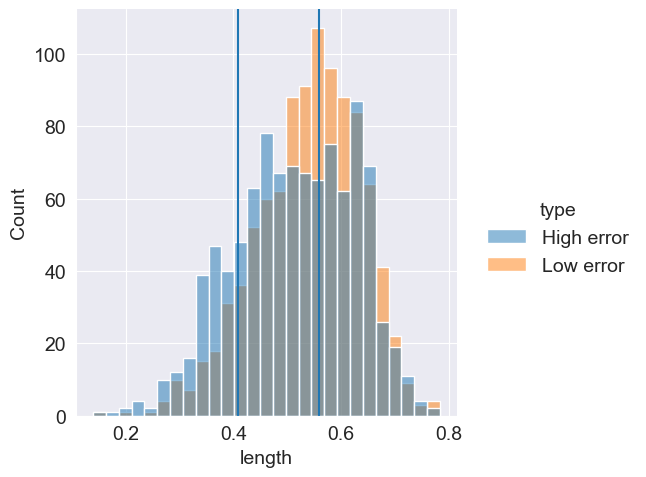

<Figure size 640x480 with 0 Axes>

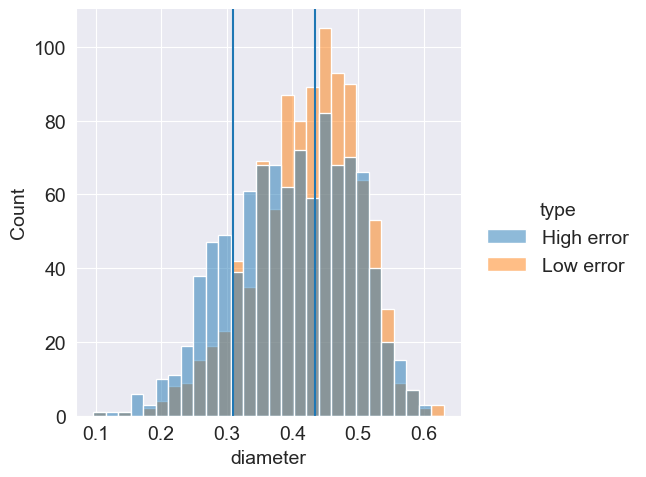

<Figure size 640x480 with 0 Axes>

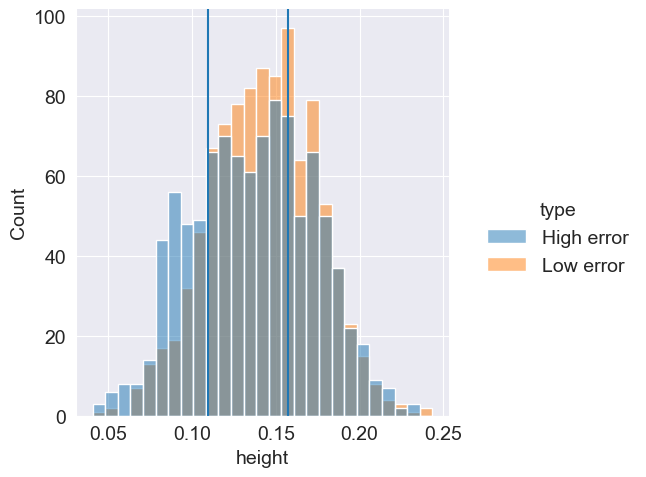

<Figure size 640x480 with 0 Axes>

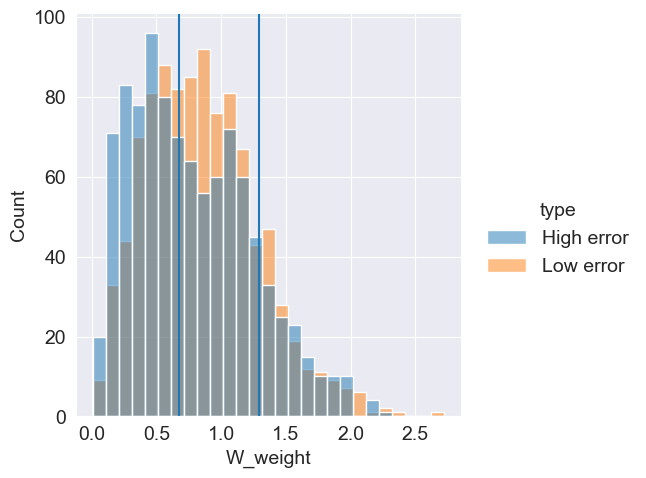

<Figure size 640x480 with 0 Axes>

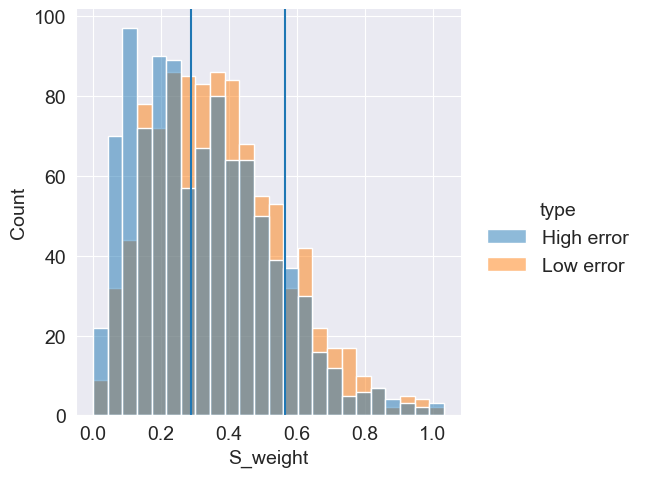

<Figure size 640x480 with 0 Axes>

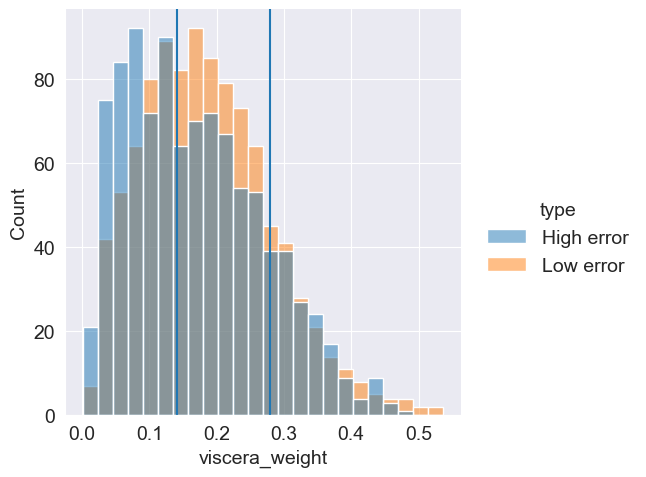

<Figure size 640x480 with 0 Axes>

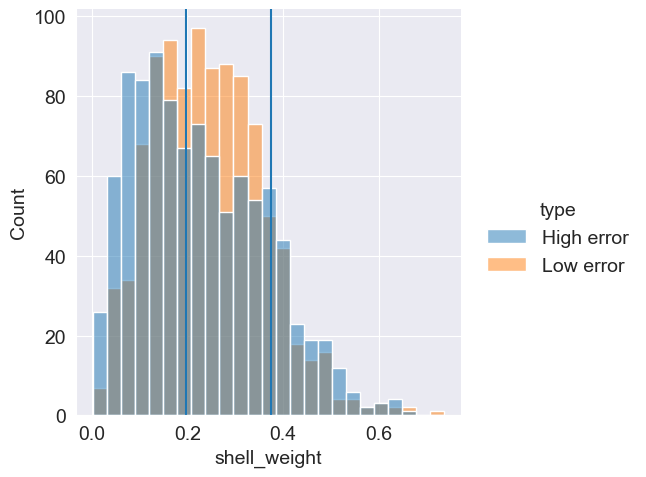

<Figure size 640x480 with 0 Axes>

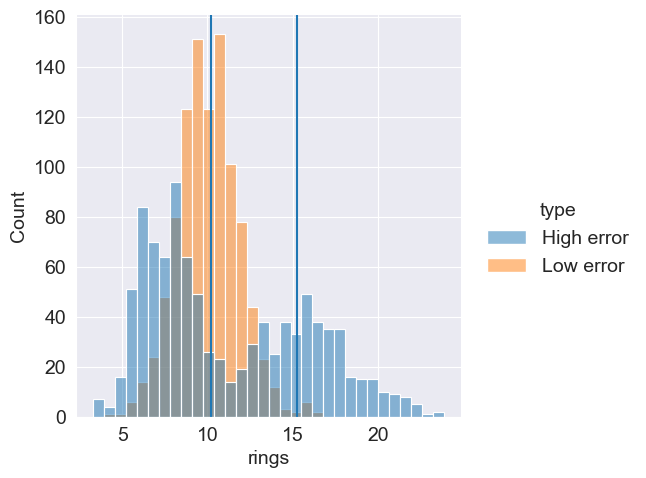

In [92]:
he_data["type"] = "High error"
le_data["type"] = "Low error"
all_data = pd.concat([he_data, le_data])
for i, feat in enumerate(features):
    plt.figure()
    sns.displot(all_data, x=feat, hue="type")
    for j in [1, 2]:
        plt.axvline(x=pipeline_data["cont_features_edges"][i][j])

In [93]:
synthetic = cbn.sample(3000)

100%|██████████| 3000/3000 [01:01<00:00, 48.81it/s]


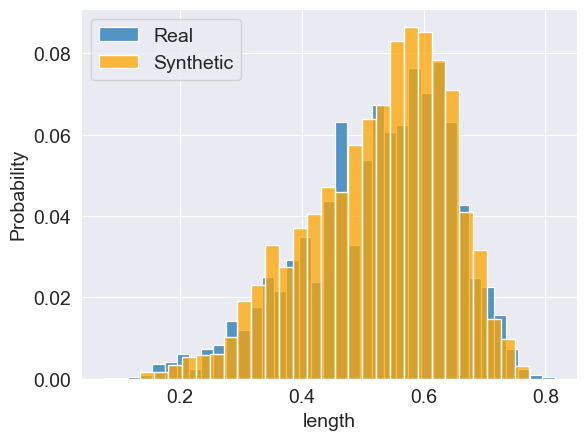

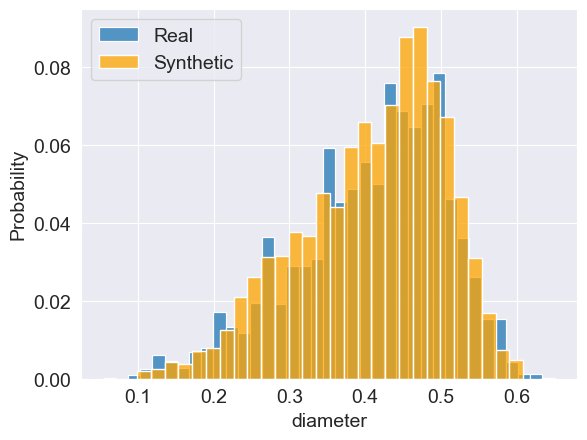

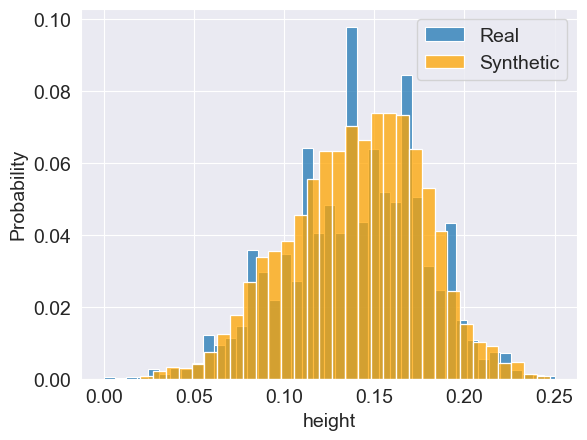

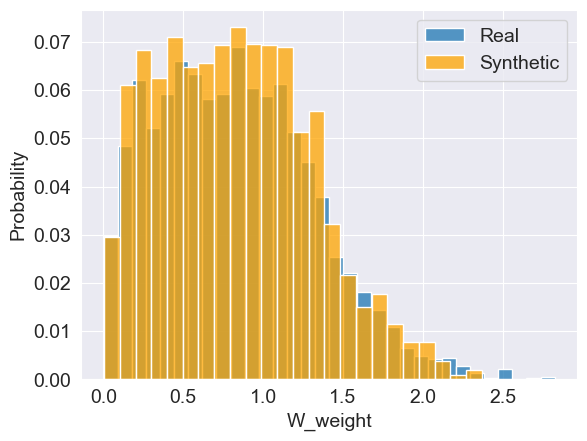

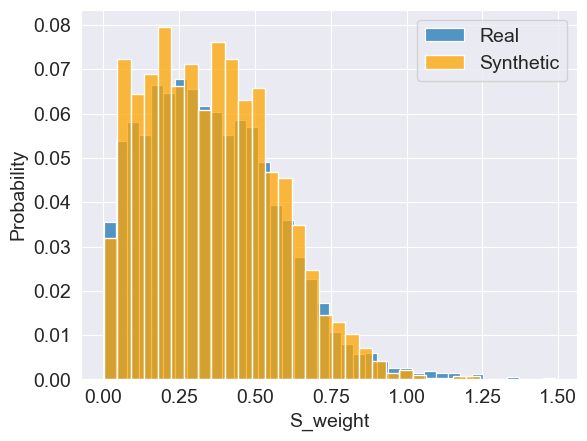

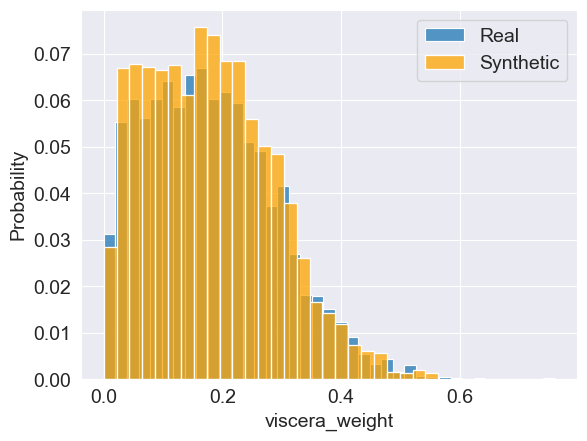

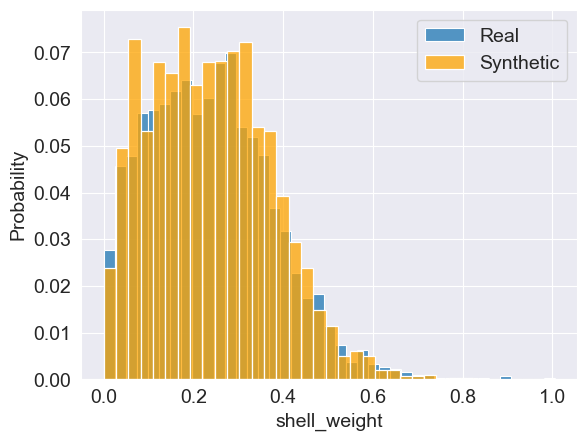

In [129]:
data_c = data_errors.copy()
data_c["type"] = "Real"
synthetic["type"] = "Synthetic"
all_data = pd.concat([data_c, synthetic])
for feat in features:
    plt.figure()
    for g, color in zip(["Real", "Synthetic"], [None, "orange"]):
        sns.histplot(all_data[all_data["type"]==g], x=feat, label=g, color=color, stat = 'probability')
        plt.legend()
    #sns.histplot(all_data, x=feat, label="Real", hue="type", stat = 'probability')

<AxesSubplot: ylabel='Frequency'>

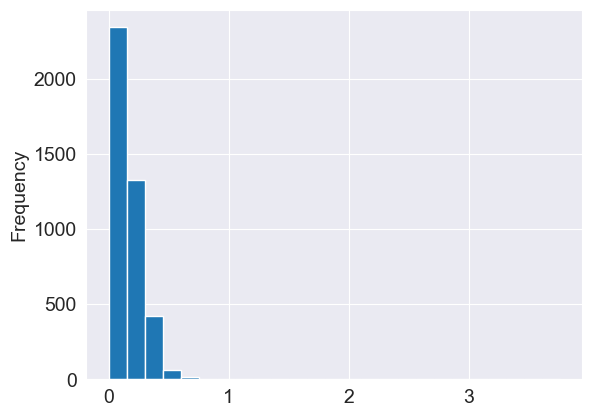

In [95]:
data_errors["ape_error"].plot.hist(bins=25)

In [96]:
pipeline_data["cont_features_edges"]

array([array([0.075     , 0.40781788, 0.55885327, 0.815     ]),
       array([0.055     , 0.30950751, 0.43446298, 0.65      ]),
       array([0.        , 0.10939743, 0.15740856, 0.25      ]),
       array([2.00000000e-03, 6.71022908e-01, 1.29029846e+00, 2.82550000e+00]),
       array([1.00000000e-03, 2.88607762e-01, 5.65832034e-01, 1.48800000e+00]),
       array([5.00000000e-04, 1.41643439e-01, 2.78531845e-01, 7.60000000e-01]),
       array([0.0015    , 0.1965031 , 0.37574715, 1.005     ]),
       array([ 1.        , 10.18734361, 15.22980591, 29.        ]),
       list([1.9341730244416443e-05, 0.0977942909241182, 0.19556924011799198, 3.760349944550234])],
      dtype=object)

Высокая ошибка

In [97]:
HEdata = cbn.sample(3000, evidence={"ape_error": 0.7})[data_errors.columns]

100%|██████████| 3000/3000 [00:44<00:00, 67.85it/s]


In [98]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score, mean_absolute_percentage_error as mape
def inconfidence_score(y_true, y_pred):
    return np.mean((1 - y_pred) * y_true + y_pred * (1 - y_true))

def inconfidence_score_ew(y_true, y_pred):
    return (1 - y_pred) * y_true + y_pred * (1 - y_true)

def mape_ew(y_true, y_pred):
    return np.abs((y_true-y_pred)/y_true)

In [99]:
model.feature_names_in_

array(['S_weight', 'W_weight', 'diameter', 'height', 'length',
       'shell_weight', 'viscera_weight'], dtype=object)

In [100]:

HEpred = model.predict(HEdata[model.feature_names_in_])
errors = mape_ew(HEdata[target].astype(int), HEpred)
error = mape(HEdata[target].astype(int), HEpred)
errors

0       0.813939
1       1.012931
2       0.474460
3       1.257276
4       1.452109
          ...   
2582    1.018110
2583    0.768528
2584    1.889614
2585    1.526505
2586    0.843364
Name: rings, Length: 2587, dtype: float64

In [101]:
error

1.0661584062561722

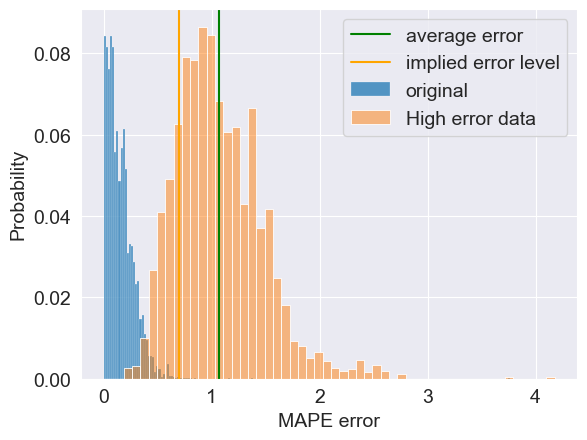

In [123]:
sns.histplot(data_errors["ape_error"], label="original", stat = 'probability')
sns.histplot(errors, label="High error data", alpha=0.5, stat = 'probability')
plt.axvline(error, label="average error", color="g")
plt.axvline(0.7, label="implied error level", color="orange")
plt.xlabel("MAPE error")
#plt.xlim((0, 1))
plt.legend()

In [109]:
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as mape

In [111]:
preds = model.predict(data[model.feature_names_in_])

In [112]:
features

['length',
 'diameter',
 'height',
 'W_weight',
 'S_weight',
 'viscera_weight',
 'shell_weight']

In [113]:
#all metrics before and after enrichment
for metric in [mape, MSE, r2_score]:
    bef = metric(data[target].astype(int), preds)
    aft = metric(HEdata[target].astype(int), HEpred)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.155 , after  1.066
Before  4.582 , after  21.713
Before  0.559 , after -7.268


In [114]:
enriched_data = pd.concat([data, HEdata[features + [target]]])
enriched_data[target] = enriched_data[target].astype(int)
model1 = copy(model)
model1.fit(enriched_data[features], enriched_data[target])


GradientBoostingRegressor(n_estimators=30)

In [116]:
predEN = model1.predict(enriched_data[features])

In [117]:
errorse = mape_ew(enriched_data[target].astype(int), predEN)
errore = mape(enriched_data[target].astype(int), predEN)
errorse

0       0.463810
1       0.171792
2       0.080186
3       0.145064
4       0.233745
          ...   
2582    0.508935
2583    0.080617
2584    0.890483
2585    0.932486
2586    0.173900
Name: rings, Length: 6762, dtype: float64

In [118]:
current_error, errore

(0.15496210534140756, 0.3065744450098139)

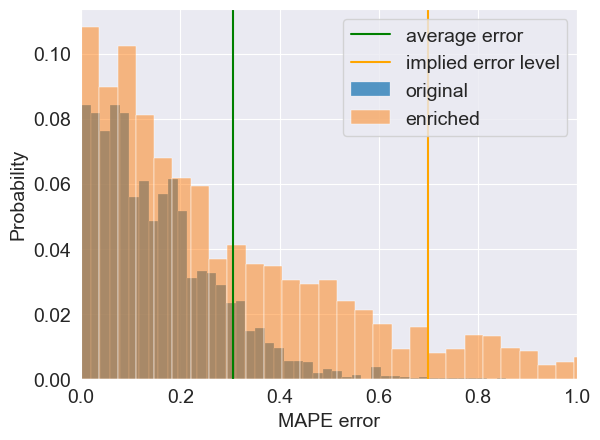

In [136]:
sns.histplot(data_errors["ape_error"], label="original", stat = 'probability')
sns.histplot(errorse, label="enriched", alpha=0.5, stat = 'probability')
plt.axvline(errore, label="average error", color="g")
plt.axvline(0.7, label="implied error level", color="orange")
plt.xlabel("MAPE error")
plt.xlim((0, 1))
plt.legend()

In [121]:
for metric in [mape, MSE, r2_score]:
    bef = metric(data[target].astype(int), preds)
    aft = metric(enriched_data[target].astype(int), predEN)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.155 , after  0.307
Before  4.582 , after  6.921
Before  0.559 , after  0.503


Низкая ошибка

In [131]:
LEdata = cbn.sample(3000, evidence={"ape_error": 0.05})[data_errors.columns]

100%|██████████| 3000/3000 [00:43<00:00, 68.51it/s]


In [132]:

LEpred = model.predict(LEdata[model.feature_names_in_])
errors_l = mape_ew(LEdata[target].astype(int), LEpred)
error_l = mape(LEdata[target].astype(int), LEpred)
errors_l

0       0.109570
1       0.150246
2       0.106994
3       0.116830
4       0.021996
          ...   
2975    0.106321
2976    0.188449
2977    0.079424
2978    0.118702
2979    0.074202
Name: rings, Length: 2980, dtype: float64

In [133]:
error_l

0.10256771387615621

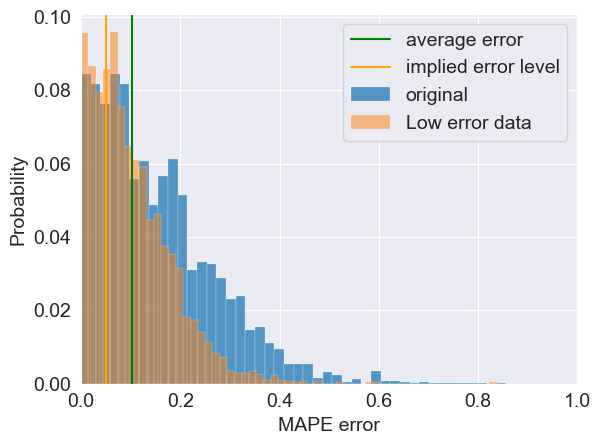

In [135]:
sns.histplot(data_errors["ape_error"], label="original", stat = 'probability')
sns.histplot(errors_l, label="Low error data", alpha=0.5, stat = 'probability')
plt.axvline(error_l, label="average error", color="g")
plt.axvline(0.05, label="implied error level", color="orange")
plt.xlim((0, 1))
plt.xlabel("MAPE error")
plt.legend()

In [137]:
#all metrics before and after enrichment
for metric in [mape, MSE, r2_score]:
    bef = metric(data[target].astype(int), preds)
    aft = metric(LEdata[target].astype(int), LEpred)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.155 , after  0.103
Before  4.582 , after  1.375
Before  0.559 , after  0.570


In [139]:
enriched_data_l = pd.concat([data, LEdata[features + [target]]])
enriched_data_l[target] = enriched_data_l[target].astype(int)
model2 = copy(model)
model2.fit(enriched_data_l[features], enriched_data_l[target])


GradientBoostingRegressor(n_estimators=30)

In [140]:
predENL = model2.predict(enriched_data_l[features])

In [141]:
errorsel = mape_ew(enriched_data_l[target].astype(int), predENL)
errorel = mape(enriched_data_l[target].astype(int), predENL)
errorsel

0       0.434862
1       0.063620
2       0.143120
3       0.080232
4       0.013963
          ...   
2975    0.137626
2976    0.186604
2977    0.088802
2978    0.083886
2979    0.100592
Name: rings, Length: 7155, dtype: float64

In [142]:
current_error, errorel

(0.15496210534140756, 0.1263145710288352)

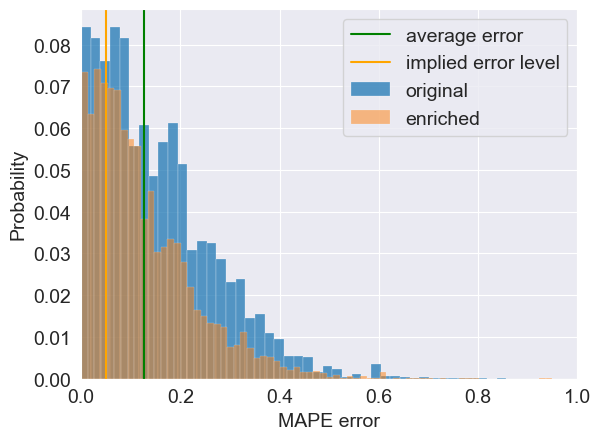

In [144]:
sns.histplot(data_errors["ape_error"], label="original", stat = 'probability')
sns.histplot(errorsel, label="enriched", alpha=0.5, stat = 'probability')
plt.axvline(errorel, label="average error", color="g")
plt.axvline(0.05, label="implied error level", color="orange")
plt.xlabel("MAPE error")
plt.xlim((0, 1))
plt.legend()

In [145]:
for metric in [mape, MSE, r2_score]:
    bef = metric(data[target].astype(int), preds)
    aft = metric(enriched_data_l[target].astype(int), predENL)
    print(f"Before {bef: .3f} , after {aft: .3f}")

Before  0.155 , after  0.126
Before  4.582 , after  3.325
Before  0.559 , after  0.552


In [16]:
from bamt.nodes.discrete_node import DiscreteNode

In [55]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [18]:
bn.distributions

{'height': {'cprob': [0.9995211874551113,
   0.00023940627244433804,
   0.00023940627244433804],
  'vals': ['0', '1', '2']},
 'shell_weight': {'cprob': {"['0']": [0.42107784431137724,
    0.4244311377245509,
    0.15449101796407186],
   "['1']": [0.0, 0.0, 1.0],
   "['2']": [1.0, 0.0, 0.0]},
  'vals': ['0', '1', '2']},
 'diameter': {'cprob': {"['0']": [0.3985218874360432,
    0.5906765207504264,
    0.010801591813530414],
   "['1']": [0.001128668171557562, 0.2652370203160271, 0.7336343115124153],
   "['2']": [0.0, 0.018575851393188854, 0.9814241486068112]},
  'vals': ['0', '1', '2']},
 'sq_error': {'cprob': {"['0']": [0.9835133598635588,
    0.01648664013644116,
    0.0],
   "['1']": [0.9554176072234764, 0.044582392776523705, 0.0],
   "['2']": [0.9287925696594427, 0.0696594427244582, 0.0015479876160990713]},
  'vals': ['0', '1', '2']},
 'W_weight': {'cprob': {"['1', '0']": [0.904716073147257,
    0.09528392685274302,
    0.0],
   "['1', '1']": [0.2, 0.7978723404255319, 0.00212765957446

In [56]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

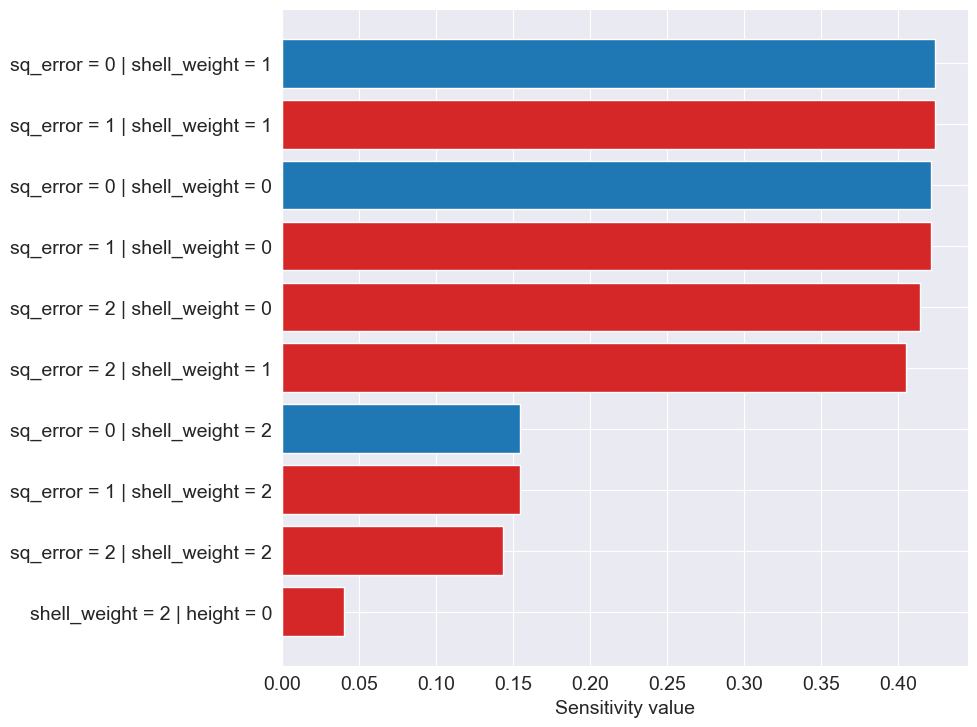

In [20]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'sq_error': 0}, nbars=10)

<Figure size 640x480 with 0 Axes>

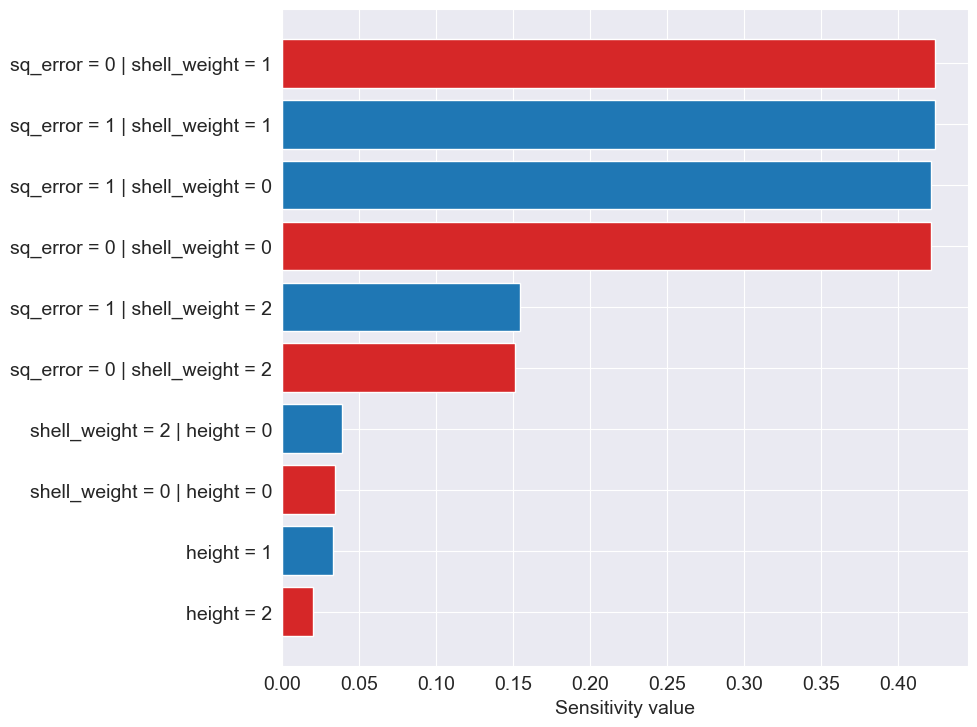

In [21]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'sq_error': 1}, nbars=10)

<Figure size 640x480 with 0 Axes>

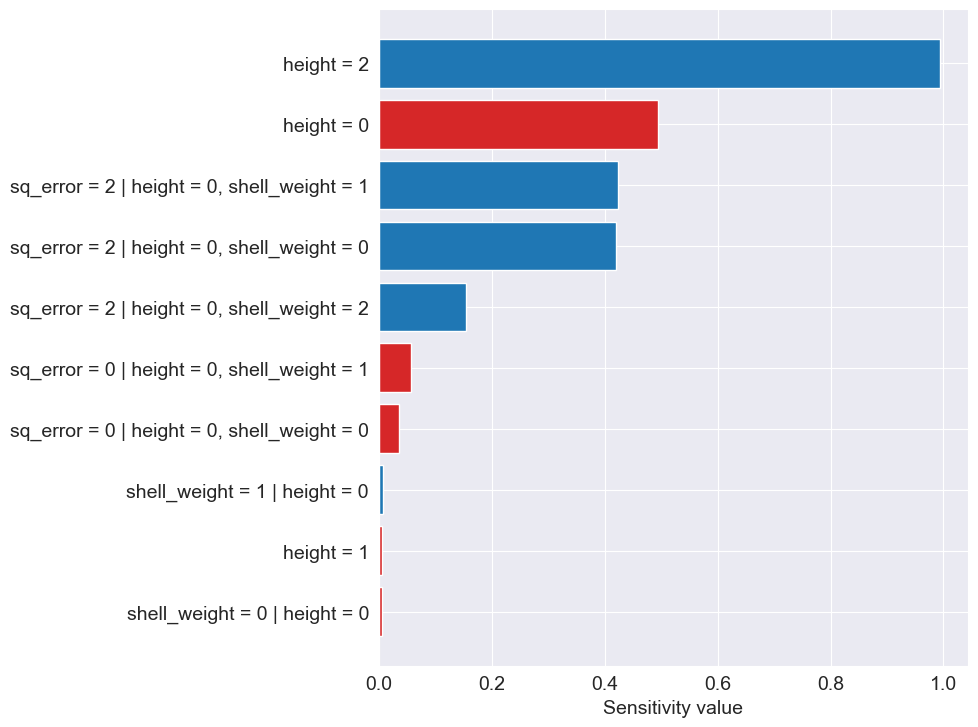

In [57]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'sq_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии среднего веса панциря

In [58]:
current_error

4.90923681581896

In [59]:
new_data = data[disc_data["shell_weight"]!=1]
new_data

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
5,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.1200,8
...,...,...,...,...,...,...,...,...
4166,0.475,0.365,0.115,0.4990,0.2320,0.0885,0.1560,10
4167,0.500,0.380,0.125,0.5770,0.2690,0.1265,0.1535,9
4168,0.515,0.400,0.125,0.6150,0.2865,0.1230,0.1765,8
4169,0.520,0.385,0.165,0.7910,0.3750,0.1800,0.1815,10


In [60]:
from copy import copy

In [25]:
model1 = copy(model)
model1.fit(new_data[features], new_data[target])

NameError: name 'new_data' is not defined

In [84]:
np.square(model1.predict(new_data[features])-new_data[target]).mean()

3.937508020828659

In [21]:
from sklearn.metrics import mean_squared_error as MSE

### Пробуем отсеивать долю наблюдений с высокой ошибкой

In [61]:
data_errors.shape, data.shape

((4177, 8), (4177, 8))

In [76]:
dfeat = ["shell_weight", "height"]
dcat = [1, 0]
#dfeat = ["height"]
#dcat = [2]
#dfeat = ["shell_weight"]
#dcat = [1]
dropping_category_minmax = data[disc_data[dfeat]==1][dfeat].min(), data[disc_data[dfeat]==1][dfeat].max()
bn = n
def bootstrap_sampling(dfeat, dcat, trials=1000, alpha=0):
    
    diffs = list()
    mses_before, mses_after = list(), list()
    n_dropped = list()
    
    #пробуем побутсрапировать выборку, чтобы оценить значимость различий в ошибках регрессии
    for i in tqdm(range(trials)):
        indexes = np.random.randint(n, size=bn)
        bsample = data.iloc[indexes]
        
        bsample_disc = pd.DataFrame(pipeline_data["transformer"].transform(bsample), columns=features+[target])
        
        mask = False
        for feat, cat in zip(dfeat, dcat):
            mask = mask | (bsample_disc[feat]==cat)
        
        X1, y1 = bsample[features], bsample[target]
        model1, model2 = copy(model), copy(model)
        model1.fit(X1, y1)
        y1_pred = model1.predict(X1)
        indexes_to_drop = np.random.choice(bsample[mask].index, size=int(np.floor(bsample[mask].shape[0]*(1-alpha))), replace=False)
        
        new_bsample = bsample.drop(index=indexes_to_drop)
        
        X2, y2 = new_bsample[features], new_bsample[target]
        
        model2.fit(X2, y2)
        
        y2_pred = model2.predict(X2)
        mses_before.append(MSE(y1, y1_pred))
        mses_after.append(MSE(y2, y2_pred))
        diffs.append(MSE(y1, y1_pred) - MSE(y2, y2_pred))
        n_dropped.append(indexes_to_drop.shape[0])
        
    return mses_before, mses_after, diffs, sum(n_dropped)/trials

In [34]:
data.shape

(4177, 8)

In [84]:
data_errors[disc_data["sq_error"]==2]["sq_error"]

480    227.955515
Name: sq_error, dtype: float64

In [69]:
np.random.seed(42)
mses_before, mses_after, diffs, mean_dropped = bootstrap_sampling(dfeat, dcat, trials=500,alpha=0.)

100%|██████████| 500/500 [00:06<00:00, 78.34it/s]


In [78]:
3303/n

0.7907589178836486

In [77]:
percentage_changes = list()
mean_differences = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    mses_before, mses_after, diffs, _ = bootstrap_sampling(dfeat, dcat, trials=500, alpha=a)
    if a == 0:
        print(_)
    x, y = np.array(mses_before), np.array(mses_after)
    mean_differences.append((x-y).mean())
    percentage_changes.append(((y-x)/x).mean()*100)
percentage_changes.append(0)
mean_differences.append(0)

100%|██████████| 500/500 [00:06<00:00, 73.71it/s]


3303.752


100%|██████████| 500/500 [00:07<00:00, 66.18it/s]


In [81]:
percentage_changes[0]

-2.801394237210811

Text(0, 0.5, 'Mean score difference')

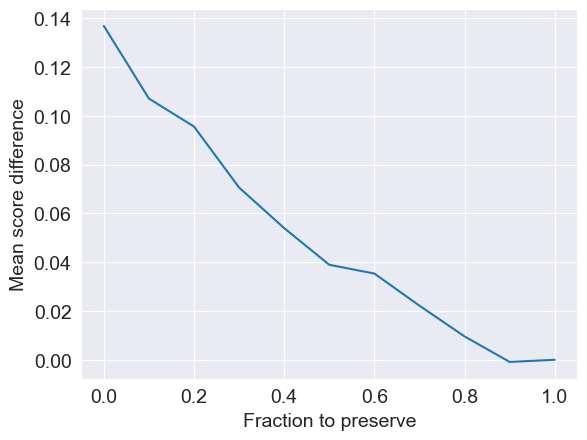

In [79]:
plt.plot(alphas, mean_differences)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score difference")

Text(0, 0.5, 'Mean score percentage change')

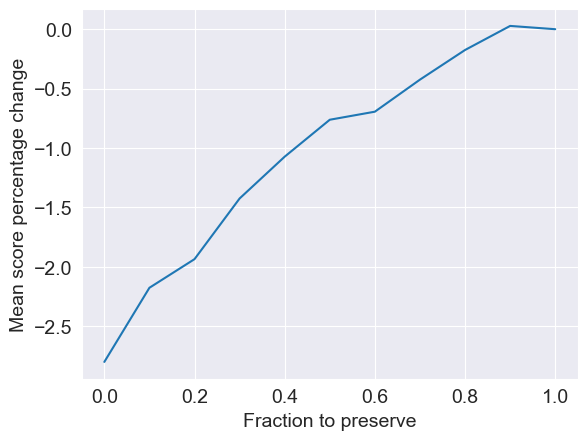

In [80]:
plt.plot(alphas, percentage_changes)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score percentage change")

# k2score boosting: shell_weight == Mid рекомендовано как градация, влияющая на ошибку больше всего
# k2score linear reg: height = High or height=Mid and Shell_weight=Low рекомендовано как градация, влияющая на ошибку больше всего

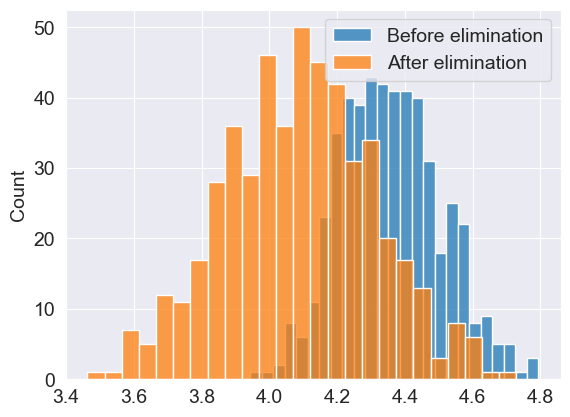

In [79]:
sns.histplot(mses_before, label="Before elimination", bins=25)
sns.histplot(mses_after, label="After elimination", bins=25)
plt.legend()

In [34]:
x, y = np.array(mses_before), np.array(mses_after)
((y-x)/x).mean()*100



-6.2094177110470605

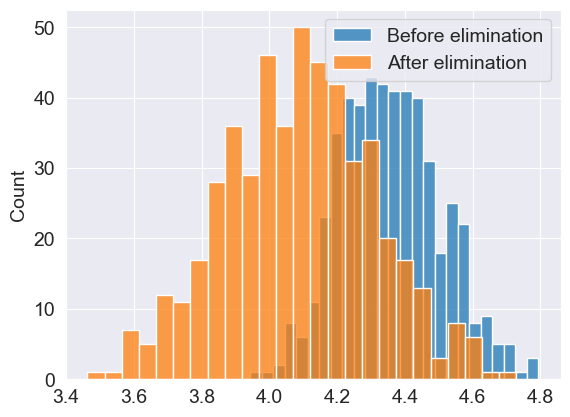

In [35]:
sns.histplot(mses_before, label="Before elimination", bins=25)
sns.histplot(mses_after, label="After elimination", bins=25)
plt.legend()

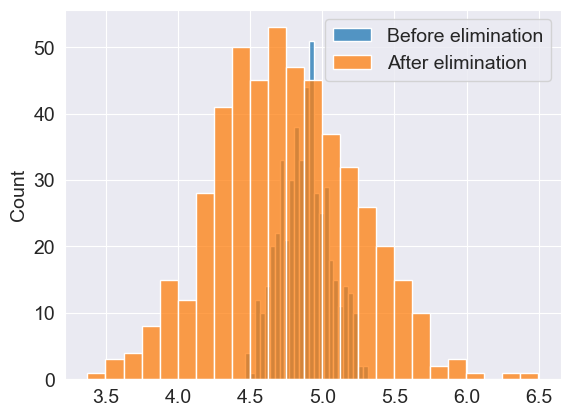

In [125]:
sns.histplot(mses_before, label="Before elimination", bins=25)
sns.histplot(mses_after, label="After elimination", bins=25)
plt.legend()

In [82]:
from scipy.stats import ttest_rel

In [83]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=-0.18907884264390978, pvalue=0.8501079016092494, df=499)

In [85]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,S_weight_0,S_weight_1,S_weight_2,W_weight_0,W_weight_1,W_weight_2,diameter_0,diameter_1,diameter_2,height_0,...,length_2,shell_weight_0,shell_weight_1,shell_weight_2,viscera_weight_0,viscera_weight_1,viscera_weight_2,sq_error_0,sq_error_1,sq_error_2
0,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0
1,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1,0,1,...,0,0,1,0,0,1,0,1,0,0
3,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
4,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4172,0,1,0,0,1,0,0,0,1,1,...,1,0,1,0,0,1,0,1,0,0
4173,0,1,0,0,1,0,0,0,1,1,...,1,0,1,0,0,1,0,1,0,0
4174,0,1,0,0,1,0,0,0,1,1,...,1,0,1,0,0,0,1,1,0,0
4175,0,1,0,0,1,0,0,0,1,1,...,1,0,1,0,0,1,0,1,0,0


In [86]:
from itertools import product

In [87]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "sq_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "sq_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", K2Score), params={"bl_add": blacklist})

2023-10-18 20:50:43,495 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-10-18 20:50:43,497 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-10-18 20:50:43,499 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-10-18 20:50:43,500 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-10-18 20:50:43,500 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-10-18 20:50:43,501 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-10-18 20:50:43,502 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-10-18 20:50:43,502 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-10-18 20:50:43,503 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-10-18 20:50:43,504 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [131]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,height_0,Discrete,disc,[],[]
1,height_1,Discrete,disc,[],[]
2,height_2,Discrete,disc,[],[]
3,shell_weight_2,Discrete,disc,[height_1],[disc]
4,W_weight_1,Discrete,disc,"[height_2, shell_weight_2]","[disc, disc]"
5,shell_weight_1,Discrete,disc,[W_weight_1],[disc]
6,S_weight_1,Discrete,disc,"[W_weight_1, height_2, shell_weight_2]","[disc, disc, disc]"
7,viscera_weight_1,Discrete,disc,"[S_weight_1, W_weight_1, shell_weight_1]","[disc, disc, disc]"
8,W_weight_2,Discrete,disc,"[S_weight_1, shell_weight_1, shell_weight_2, v...","[disc, disc, disc, disc]"
9,S_weight_2,Discrete,disc,"[W_weight_1, W_weight_2]","[disc, disc]"


# k2score boosting: нет рекомендаций
# k2score boosting: height = High и Mid рекомендованы к удалению

In [88]:
np.random.seed(42)

dfeat = ["length", "height"]
dcat = [1, 2]

#mses_before, mses_after, diffs, _ = bootstrap_sampling(dfeat, dcat, trials=500)

In [89]:
percentage_changes = list()
mean_differences = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    mses_before, mses_after, diffs, _ = bootstrap_sampling(dfeat, dcat, trials=500, alpha=a)
    if a == 0:
        print(_)
    x, y = np.array(mses_before), np.array(mses_after)
    mean_differences.append((x-y).mean())
    percentage_changes.append(((y-x)/x).mean()*100)
percentage_changes.append(0)
mean_differences.append(0)

100%|██████████| 500/500 [00:06<00:00, 71.58it/s]


2280.792


100%|██████████| 500/500 [00:06<00:00, 79.53it/s]


In [92]:
2280./n

0.5458463011730907

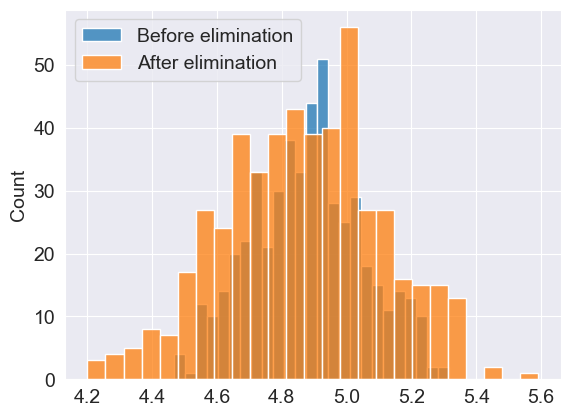

In [40]:
sns.histplot(mses_before, label="Before elimination", bins=25)
sns.histplot(mses_after, label="After elimination", bins=25)
plt.legend()

Text(0, 0.5, 'Mean score difference')

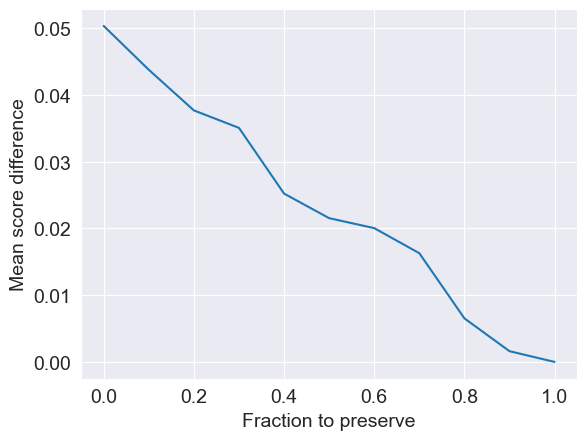

In [90]:
plt.plot(alphas, mean_differences)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score difference")

Text(0, 0.5, 'Mean score percentage change')

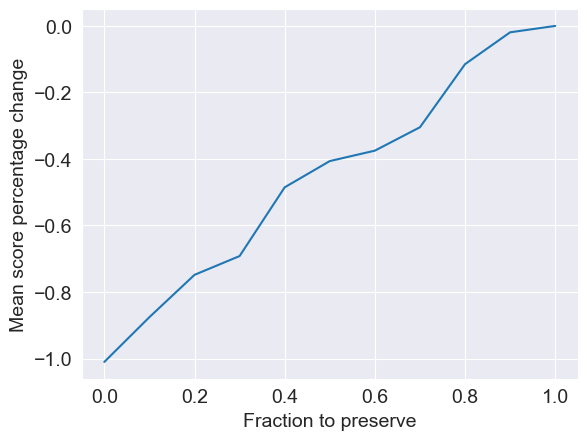

In [91]:
plt.plot(alphas, percentage_changes)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score percentage change")

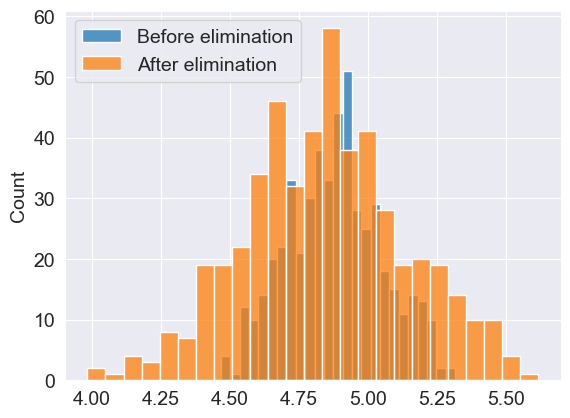

In [133]:
sns.histplot(mses_before, label="Before elimination", bins=25)
sns.histplot(mses_after, label="After elimination", bins=25)
plt.legend()

In [134]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=2.9847571378258984, pvalue=0.002977257506233751, df=499)

In [42]:
disc_data_encoded = OneHotEncoder(sparse_output=False, dtype=np.int8).fit_transform(disc_data)
disc_data_encoded

array([[1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0]], dtype=int8)

In [ ]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_onehot = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')

In [ ]:
disc_data_onehot

In [ ]:
gbn = DiscreteBNGI(imagespath)

In [ ]:
variables=["X1", "X2"]
#gbn.add_nodes(kresult["bn"].descriptor)
#grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
#gbn.set_edges(grad_edges)
gbn.add_edges(data=disc_data_onehot, scoring_function=("K2", K2Score))

In [ ]:
c=gbn.plot("regression.html")

In [ ]:
disc_data_errors, pipeline_data_errors = discretize(data_errors, variables=data_errors.columns.tolist(), icat=None, icont=[0, 1])

In [ ]:
disc_data_errors

In [ ]:
kresultresid = construct_by_kmeans(data_residuals, [], scoring=("K2", K2Score))

In [ ]:
c=kresultresid["bn"].plot2(imagespath, "residuals.html")